In [455]:
import gymnasium as gym
import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import optuna
import wandb
from tqdm import tqdm
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from gymnasium.vector import AsyncVectorEnv, SyncVectorEnv
from collections import deque

In [456]:
# Environment setup
env = gym.make('FrozenLake-v1', is_slippery=False)
n_actions = env.action_space.n
n_states = env.observation_space.n

In [457]:
# Neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(n_states, n_actions)

    def forward(self, x):
        return self.fc(x)
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.match_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        residual = self.match_channels(x)
        out = F.relu(self.bn(self.conv(x)))
        return out + residual

class ConvNet(nn.Module):
    def __init__(self, input_size, n_actions, conv_layers=None, dropout_p=None):
        super(ConvNet, self).__init__()

        if conv_layers is None:
            conv_layers = [16, 32]
        layers = []
        in_channels = 4  # Initial number of channels

        for out_channels in conv_layers:
            layers.append(ConvBlock(in_channels, out_channels))
            #if dropout_p is not None:
                #layers.append(nn.Dropout(dropout_p))
            in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)
        self.fc = nn.Linear(conv_layers[-1] * input_size, n_actions)
        self.dropout_p = dropout_p

        if dropout_p is not None:
            self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
            #if self.dropout_p is not None:
            #    x = self.dropout(x)

        x = x.view(x.size(0), -1)
        if self.dropout_p is not None:
            x = self.dropout(x)
        return self.fc(x)

In [458]:
# parameter count
model_to_count = ConvNet(n_states, n_actions)
sum(p.numel() for p in model_to_count.parameters() if p.requires_grad)

8004

In [459]:
def actions_from_q_values(q_values, epsilon):
    """
    Selects actions according to epsilon-greedy policy.
    """
    if random.random() < epsilon:
        return random.randint(0, n_actions - 1)
    else:
        # Apply softmax to convert q_values into probabilities
        probabilities = torch.nn.functional.softmax(q_values, dim=1)
        
        # Sample actions based on the probabilities
        actions = np.array([torch.multinomial(p, 1).item() for p in probabilities]).cpu().numpy()
        return actions


In [460]:
device = torch.device("mps")

In [461]:
def preprocess_state(position, map_layout):
    nrows, ncols = len(map_layout), len(map_layout[0])   # Corrected for variable column length
    num_statuses = 4      # Four statuses including the agent's position

    state_tensor = np.zeros((nrows, ncols, num_statuses))

    # Decode map layout
    layout_to_val = {b'F': 0, b'H': 1, b'S': 0, b'G': 3}  # Start 'S' also considered safe '0'

    for i in range(nrows):
        for j in range(ncols):
            # Set the appropriate index in the one-hot vector
            state_tensor[i, j, layout_to_val[map_layout[i][j]]] = 1

    # Convert position to 2D coordinates and update in state tensor
    row, col = divmod(position, ncols)
    # Resetting the cell to a blank state before marking the current position
    state_tensor[row, col] = np.array([0, 0, 0, 0])
    state_tensor[row, col, 2] = 1  # Marking the current position with one-hot encoding

    # Rearrange the tensor to (channels, rows, columns)
    state_tensor = np.transpose(state_tensor, (2, 0, 1))

    return torch.tensor(state_tensor, dtype=torch.float)


def preprocess_states_batch(positions, map_layouts):
    nrows, ncols = len(map_layouts[0]), len(map_layouts[0])  # Assuming a 4x4 map
    num_statuses = 4     # Four statuses including the agent's position
    batch_size = len(positions)

    # Initialize a tensor for the batch of states
    state_tensor = np.zeros((batch_size, nrows, ncols, num_statuses))

    layout_to_val = {b'F': 0, b'H': 1, b'S': 0, b'G': 3}  # Start 'S' also considered safe '0'

    for b in range(batch_size):
        position = positions[b]
        map_layout = map_layouts[b]

        for i in range(nrows):
            for j in range(ncols):
                state_tensor[b, i, j, layout_to_val[map_layout[i][j]]] = 1

        # Convert position to 2D coordinates and update in state tensor
        row, col = divmod(position, ncols)
        # Resetting the cell to a blank state before marking the current position
        state_tensor[b, row, col] = np.array([0, 0, 0, 0])
        state_tensor[b, row, col, 2] = 1  # Marking the current position with one-hot encoding
    # Transpose the tensor to the format [batch_size, channels, height, width]
    state_tensor = state_tensor.transpose(0, 3, 1, 2)

    return torch.tensor(state_tensor, dtype=torch.float)



In [462]:
print(env.desc)

[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]


In [463]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, device='cpu'):
        self.alpha = alpha
        self.buffer = deque(maxlen=capacity)
        self.priorities = torch.zeros(capacity, device=device)
        self.precomputed_probabilities = None  # New attribute
        self.next_priority_idx = 0
        self.device = device

    def __len__(self):
        return len(self.buffer)

    def push(self, experiences):
        # Convert a batch of experiences to tensors
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = torch.stack(states).to(self.device)
        actions = torch.tensor(actions, device=self.device, dtype=torch.int64)
        rewards = torch.tensor(rewards, device=self.device, dtype=torch.float32)
        next_states = torch.stack(next_states).to(self.device)
        dones = torch.tensor(dones, device=self.device, dtype=torch.float32)

        max_priority = self.priorities.max().item()
        for idx in range(len(experiences)):
            self.buffer.append((states[idx], actions[idx], rewards[idx], next_states[idx], dones[idx]))
            self.priorities[self.next_priority_idx] = max_priority
            self.next_priority_idx = (self.next_priority_idx + 1) % len(self.priorities)
        self._update_probabilities()

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == 0 or self.precomputed_probabilities is None:
            return torch.empty(0), torch.empty(0, dtype=torch.long), torch.empty(0)

        indices = torch.multinomial(self.precomputed_probabilities, batch_size, replacement=True)

        # Extracting the samples based on indices
        states, actions, rewards, next_states, dones = zip(*[self.buffer[idx] for idx in indices])
        states = torch.stack(states)
        actions = torch.stack(actions)
        rewards = torch.stack(rewards)
        next_states = torch.stack(next_states)
        dones = torch.stack(dones)

        weights = (len(self.buffer) * self.precomputed_probabilities[indices]) ** (-beta)
        weights /= weights.max()

        return (states, actions, rewards, next_states, dones), indices, weights

    def update_priorities(self, indices, errors):
        self.priorities[indices] = torch.tensor(errors, device=self.device) + 1e-5
        self._update_probabilities()

    def _update_probabilities(self):
        # Update the precomputed probabilities based on current priorities
        priorities = self.priorities[:len(self.buffer)].clamp(min=1e-5)
        self.precomputed_probabilities = priorities ** self.alpha
        self.precomputed_probabilities /= self.precomputed_probabilities.sum()


In [464]:
def calculate_intermediate_reward(current_state, next_state, env, visited_states, forward_step_reward=0, visited_step_reward=0, in_place_reward=0):
    """
    Calculate intermediate reward based on movement towards the goal.
    """
    if next_state == current_state:
        return in_place_reward
    elif next_state in visited_states:
        return visited_step_reward 
    else:
        return forward_step_reward if next_state > current_state else 0


def create_vectorized_environments(env_name, n_envs, random_map, is_slippery, size=4):
    if random_map:
        envs = [gym.make(env_name, desc=generate_random_map(size=size), is_slippery=is_slippery) for _ in range(n_envs)]
    else:
        envs = [gym.make(env_name, is_slippery=is_slippery) for _ in range(n_envs)]
    return envs

def create_environment(random_map, is_slippery, size=4):
    if random_map:
        return gym.make('FrozenLake-v1', desc=generate_random_map(size=size), is_slippery=is_slippery)
    else:
        return gym.make('FrozenLake-v1', is_slippery=is_slippery)


def update_model_using_replay_buffer(buffer:PrioritizedReplayBuffer, model, model2, optimizer, loss_fn, gamma, device, gradient_clipping_max_norm=10.0, batch_size=256, beta=0.4, return_grad_norm=False):
    model.train()
    
    # Sample a batch of transitions from the replay buffer
    (states_batch, actions_batch, rewards, next_states_batch, dones), indices, weights = buffer.sample(batch_size, beta=beta)
    
    # to device
    states_batch = states_batch.to(device)
    actions_batch = actions_batch.to(device)
    rewards = rewards.to(device)
    next_states_batch = next_states_batch.to(device)
    dones = dones.to(device)
    weights = weights.to(device)
    
    # Compute the target Q-values
    with torch.no_grad():
        next_q_values = model2(next_states_batch).gather(1, torch.argmax(model(next_states_batch), dim=1).unsqueeze(-1)).squeeze()
        target_q_values = rewards + gamma * next_q_values * (1 - dones)
    
    
    # Reshape actions_batch from [64] to [64, 1] to match the dimensions
    actions_batch = actions_batch.unsqueeze(-1)
    # Compute current Q-values using the sampled states and actions
    current_q_values = model(states_batch).gather(1, actions_batch).squeeze(-1)
    
    # Compute the loss
    loss = loss_fn(current_q_values, target_q_values)
    
    # Calculate TD error for priority update
    errors = torch.abs(current_q_values - target_q_values).detach().cpu().numpy()
    buffer.update_priorities(indices, errors)
    
    loss = (loss * weights).mean()
    
    # Rest of your optimization logic
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clipping_max_norm)
    optimizer.step()
    
    if return_grad_norm:
        grad_norm = sum(torch.norm(param.grad)**2 for param in model.parameters() if param.grad is not None)
    else:
        grad_norm = None
    
    return loss, grad_norm


# Training Function
def train_model(model, create_model, optimizer, loss_fn, gamma, epsilon_start, epsilon_decay, num_steps, device, n_states, random_map=False, is_slippery=False, hole_reward=0, forward_step_reward=0, visited_step_reward=0, in_place_reward=0, step_reward=0, minimum_epsilon=0.05, gradient_clipping_max_norm=10.0, batch_size=64, buffer_alpha=0.6, beta=0.4, beta_increment=0.001, model2_step_update_frequency=750):
    n_envs = batch_size//4
    max_steps = n_states * 2
    map_size = int(n_states**0.5)
    epsilon = epsilon_start

    last_eval_success_rate = 0 # metric that is sparsely updated
    weight_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() > 1)
    bias_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() == 1)

    percentage_update = 5
    plot_update_frequency = int(num_steps * (percentage_update/100))  # update plots every % of episodes
    if plot_update_frequency == 0:
        plot_update_frequency = 1

    #double Q learning
    model2 = create_model(n_states, n_actions).to(device)
    model2.load_state_dict(model.state_dict())
    model2.eval()
    
    #Prioritized Experience Replay
    buffer = PrioritizedReplayBuffer(capacity=10000, alpha=buffer_alpha)
    min_buffer_size = 1000
    
    envs = create_vectorized_environments('FrozenLake-v1', n_envs, random_map, is_slippery, size=map_size)
    descs = [env.desc for env in envs]
    states = [env.reset()[0] for env in envs]
    visited_states = [set() for _ in envs]
    episode_steps_count = [0] * n_envs

    
    # Training loop
    for step in tqdm(range(num_steps)):
        if step % model2_step_update_frequency == 0:
            model2.load_state_dict(model.state_dict())
            model2.eval()
        
        if beta < 1:
            beta += beta_increment
        else:
            beta = 1
            
        # account for steps and visited states
        for i in range(len(envs)):
            episode_steps_count[i] += 1
            visited_states[i].add(states[i])

        # Preprocess all states and convert them into tensors
        #state_tensors = [preprocess_state(state, env.desc) for state, env in zip(states, envs)] 
        step_state_tensors = preprocess_states_batch(states, descs).to(device)

        
        # Compute Q-values for the entire batch
        with torch.no_grad():
            step_q_values = model(step_state_tensors)
        
        # Iterate over each environment to select actions
        step_actions = []
        for i, (q_values, env) in enumerate(zip(step_q_values, envs)):
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = torch.argmax(q_values).item()
            step_actions.append(action)


        step_next_states, step_rewards, step_next_dones = [], [], []
        for i, (env, action) in enumerate(zip(envs, step_actions)):
            next_state, reward, done, _, _ = env.step(action)
            # Custom reward logic
            if done and reward == 0:  # Agent fell into a hole
                reward = hole_reward
            else:
                # Additional logic to calculate reward for moving towards the goal
                reward += calculate_intermediate_reward(states[i], next_state, env, visited_states[i], forward_step_reward, visited_step_reward, in_place_reward)
            
            reward += step_reward
            step_next_states.append(next_state)
            step_rewards.append(reward)
            step_next_dones.append(done)
        
        # Store the transition in the replay buffer
        #TODO: maybe store .desc somewhere
        #state_to_push = preprocess_states_batch(states, descs)
        next_state_to_push = preprocess_states_batch(step_next_states, descs)
        experiences = []
        for state, action, reward, next_state, done in zip(step_state_tensors, step_actions, step_rewards, next_state_to_push, step_next_dones):
            experiences.append((state, action, reward, next_state, done))
        # Push the batch of experiences to the buffer
        buffer.push(experiences)

            
        if len(buffer) > min_buffer_size:
            loss, _ = update_model_using_replay_buffer(buffer, model, model2, optimizer, loss_fn, gamma, device, gradient_clipping_max_norm, batch_size, beta=beta)

            # log metrics to wandb
            wandb.log({"loss": loss.item(),
                       "weight_norm": weight_norm.item(),
                       "bias_norm": bias_norm.item(),
                       #"grad_norm": grad_norm.item(),
                       "epsilon": epsilon,
                       "last_eval_success_rate": last_eval_success_rate,
                       "beta": beta})
        #outside of buffer sampling

        # Update states of ongoing indices
        for i, (next_state, done) in enumerate(zip(step_next_states, step_next_dones)):
            if not done and episode_steps_count[i] < max_steps:
                states[i] = next_state
            else:
                # generate new env
                envs[i].close() #TODO: is this necessary?
                envs[i] = create_environment(random_map, is_slippery, size=map_size)
                descs[i] = envs[i].desc
                states[i] = envs[i].reset()[0]
                visited_states[i] = set()
                episode_steps_count[i] = 0

        # Decay epsilon
        if epsilon > minimum_epsilon:
            epsilon *= epsilon_decay

        if step > 0 and (step % plot_update_frequency == 0 or step == num_steps - 1):
            # update some metrics  
            last_eval_success_rate = evaluate_model(model, 1000, device, n_states, batch_size, is_slippery, random_map)
            weight_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() > 1)
            bias_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() == 1) 
            
    # Close all environments
    for env in envs:
        env.close()

    return model, buffer

In [465]:
def evaluate_model(model, min_eval_episodes, device, n_states, batch_size=64, is_slippery=False, random_map=False):
    map_size = int(n_states**0.5)
    model.eval()
    with torch.no_grad():
        successful_episodes = 0
        total_evaluated = 0
        envs = [create_environment(random_map, is_slippery, size=map_size) for _ in range(batch_size)]
        states = [env.reset()[0] for env in envs]
        descs = [env.desc for env in envs]
        dones = [False] * len(envs)
        max_steps = n_states
        episode_steps_count = [0] * len(envs)

        while total_evaluated < min_eval_episodes:
            state_tensors = preprocess_states_batch(states, descs).to(device)
            q_values = model(state_tensors)
            actions = torch.argmax(q_values, dim=1).cpu().numpy()

            for i in range(len(envs)):
                if not dones[i]:
                    next_state, reward, done, _, _ = envs[i].step(actions[i])
                    states[i] = next_state
                    episode_steps_count[i] += 1

                    if done or episode_steps_count[i] >= max_steps:
                        successful_episodes += 1 if reward >= 1 else 0 
                        total_evaluated += 1

                        if total_evaluated < min_eval_episodes:
                            envs[i] = create_environment(random_map, is_slippery, size=map_size)
                            descs[i] = envs[i].desc
                            states[i] = envs[i].reset()[0]
                            episode_steps_count[i] = 0
                            dones[i] = False
                        else:
                            dones[i] = True
        success_rate = successful_episodes / total_evaluated
    return success_rate


In [466]:
# Optuna Objective Function
def objective(trial):
    wandb.init(project="frozenlake_slipperry_optuna_reward_search_convnet_random_map",
               name=f"trial_{trial.number}",
               config=trial.params,
               reinit=True)
    # find rewards
    hole_reward = trial.suggest_float("hole_reward", -1, 0)
    forward_step_reward = trial.suggest_float("forward_step_reward", 0, 1)
    visited_step_reward = trial.suggest_float("visited_step_reward", -1, 0)
    
    # Hyperparameters
    learning_rate = 0.0001
    gamma = 0.99
    epsilon = 0.8
    epsilon_decay = 0.999
    num_episodes = 2500

    n_actions = env.action_space.n
    n_states = env.observation_space.n
    model = ConvNet(n_states, n_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss().to(device)
    random_map = True
    is_slippery = False

    #TODO: update parameters
    trained_model, _ = train_model(model, optimizer, loss_fn, gamma, epsilon, epsilon_decay, num_episodes, device, n_states, random_map=random_map, is_slippery=is_slippery,
                                hole_reward=hole_reward, forward_step_reward=forward_step_reward, visited_step_reward=visited_step_reward)
    
    num_eval_episodes = 50 
    success_rate = evaluate_model(trained_model, num_eval_episodes, device, n_states, is_slippery, random_map)


    wandb.finish()
    return success_rate


study

In [467]:
"""
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
"""

'\nstudy = optuna.create_study(direction=\'maximize\')\nstudy.optimize(objective, n_trials=50)\n\nprint("Best trial:")\ntrial = study.best_trial\nprint(f" Value: {trial.value}")\nprint(" Params: ")\nfor key, value in trial.params.items():\n    print(f"    {key}: {value}")\n'

In [468]:
# Hyperparameters
learning_rate = 0.0001
gamma = 0.95
epsilon = 0.6   
epsilon_decay = 0.99
weight_decay = 1e-4
dropout_p = 0.1
forward_step_reward = 0 #0.05
visited_step_reward = 0
hole_reward = 0 #-0.5
in_place_reward = 0
step_reward = 0# -0.03
min_epsilon = 0.05
gradient_clipping_max_norm = 2.0
batch_size= 128
buffer_alpha=0.3
beta=0.4
beta_increment=0
model2_step_update_frequency = 750
layers = [16, 32, 64]

In [469]:
random_map = True
is_slippery = False

In [ ]:
# Train the model
num_steps = 10_000
n_actions = env.action_space.n
size = 8
n_states = size*size
def create_convnet_model(n_states, n_actions):
    return ConvNet(n_states, n_actions,conv_layers=layers, dropout_p=dropout_p)
model = create_convnet_model(n_states, n_actions).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
wandb.init(project="frozenlake_slipperry_batches_convnet_random_map",
           name="8 sized map",
           reinit=True,
           config={"learning_rate": learning_rate,
                   "gamma": gamma,
                   "epsilon": epsilon,
                   "epsilon_decay": epsilon_decay,
                   "weight_decay": weight_decay,
                   "dropout_p": dropout_p,
                   "num_steps": num_steps,
                   "random_map": random_map,
                   "is_slippery": is_slippery,
                   "forward_step_reward": forward_step_reward,
                   "visited_step_reward": visited_step_reward,
                   "hole_reward": hole_reward,
                   "in_place_reward": in_place_reward,
                   "step_reward": step_reward,
                   "minimum_epsilon": min_epsilon,
                   "gradient_clipping_max_norm": gradient_clipping_max_norm,
                   "batch_size": batch_size,
                   "buffer_alpha": buffer_alpha,
                   "beta": beta,
                   "beta_increment": beta_increment,
                   "model2_step_update_frequency": model2_step_update_frequency,
                   "layers": layers})
model, _ = train_model(model, create_convnet_model, optimizer, loss_fn, gamma, epsilon, epsilon_decay, num_steps, device, n_states, 
                    random_map=random_map, is_slippery=is_slippery,
                    forward_step_reward=forward_step_reward,
                    visited_step_reward=visited_step_reward,
                    hole_reward=hole_reward,
                    in_place_reward=in_place_reward,
                    step_reward=step_reward,
                    minimum_epsilon=min_epsilon,
                    gradient_clipping_max_norm=gradient_clipping_max_norm,
                    batch_size=batch_size,
                    buffer_alpha=buffer_alpha,
                    beta=beta,
                    beta_increment=beta_increment,
                    model2_step_update_frequency=model2_step_update_frequency)
wandb.finish()  

 75%|███████▌  | 7544/10000 [07:00<02:01, 20.20it/s]

In [391]:
# save model
torch.save(model.state_dict(), "frozenlake_convnet_random_map_96.pt")

In [339]:
# try model finetune, with lower learning rate and no intermediate rewards
# load model and finetune
model = ConvNet(n_states, n_actions, dropout_p=dropout_p).to(device)
model.load_state_dict(torch.load("frozenlake_convnet_random_map.pt"))
optimizer = optim.Adam(model.parameters(), lr=learning_rate/10, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
num_episodes = 250
epsilon = 0
epsilon_decay = 0.99
batch_size = 64
wandb.init(project="frozenlake_slipperry_batches_convnet_random_map",
           name=f"fine tune of previous model, with 10 lower lr, but with rewards and epsilon 0",
           reinit=True,
           config={"learning_rate": learning_rate,
                   "gamma": gamma,
                   "epsilon": epsilon,
                   "epsilon_decay": epsilon_decay,
                   "weight_decay": weight_decay,
                   "dropout_p": dropout_p,
                   "num_episodes": num_episodes,
                   "random_map": random_map,
                   "is_slippery": is_slippery,
                   "forward_step_reward": forward_step_reward,
                   "visited_step_reward": visited_step_reward,
                   "hole_reward": hole_reward,
                   "in_place_reward": in_place_reward,
                   "step_reward": step_reward,
                   "minimum_epsilon": min_epsilon,
                   "gradient_clipping_max_norm": gradient_clipping_max_norm,
                   "batch_size": batch_size})
model, _ = train_model(model, optimizer, loss_fn, gamma, epsilon, epsilon_decay, num_episodes, device, n_states, 
                    random_map=random_map, is_slippery=is_slippery,
                    forward_step_reward=forward_step_reward,
                    visited_step_reward=visited_step_reward,
                    hole_reward=hole_reward,
                    in_place_reward=in_place_reward,
                    step_reward=step_reward,
                    minimum_epsilon=min_epsilon,
                    gradient_clipping_max_norm=gradient_clipping_max_norm,
                    batch_size=batch_size)
wandb.finish()  


100%|██████████| 250/250 [04:25<00:00,  1.06s/it]


average_episode_rewards,▁▆▁▁▇▁▆▇▁▆▁▁▁▁▁▁▄▅▇▁▁▅▁▁▆▅▆▃▅▁▁▁▅█▆▁█▁▁▁
beta,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
bias_norm,██████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁
epsilon,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm,▃▅▄█▆▇▄▅▃▅▃▃▃▂▃▃▃▂▁▅▅▂▅▃▃▃▅▅▂▃▁▁▂▂▁▃▂▂▂▂
last_eval_success_rate,▇▇▇▆▆▇██▆▆▆▆▃▃▁▁▁▂▄▄▄▄▄▄▄▃▃▄▄▅▅▅▅▄▄▄▂▂▅▅
loss,▂▅▅█▆▅▅▄▅▅▃▃▃▄▄▅▄▃▂▅▇▁▆▄▄▃▃▇▂▄▂▁▃▃▂▃▃▁▂▃
weight_norm,█████▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
average_episode_rewards,0.8125
beta,1.0
bias_norm,40.40336


In [ ]:
#TODO: setup infra to understand model and where it fails:
    # keep in memory failures at each eval, and replay them to see improvements
    # have something that shows only failures
    # introspection into the buffer
#TODO: try filling the buffer with correct runs before training, see if it improves learning    
#TODO: try step small negative reward to avoid loops=> not bad, i guess it works
#TODO: try sampling other than argmax => softmax was shit, didn't learn, maybe at evaluation time it can be good
#TODO: try intermediate goals instead of rewards, for exemple moving the goal closer to the start
#TODO: try other RL algorithms => 2Q learning done
#TODO: maybe remove some intermediate rewards with time.
#TODO: how to understand what is the issue in training: for exemple when the model is chasing a Q target that is moving(2Q not imlemented or bad hyper)

In [422]:
# Evaluate the model
min_eval_episodes = 1000
success_rate = evaluate_model(model, min_eval_episodes, device, n_states, batch_size=256, is_slippery=is_slippery, random_map=random_map)
print(f"Success Rate: {success_rate:.3f}")

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (256x1024 and 4096x4)

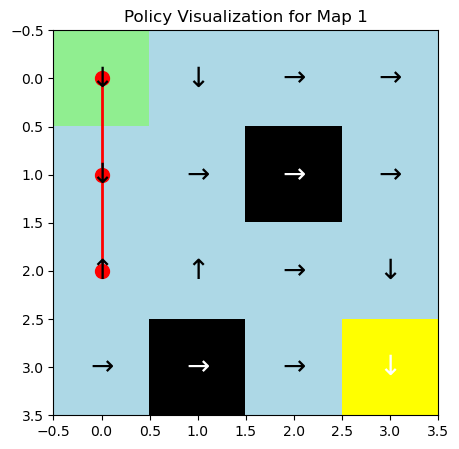

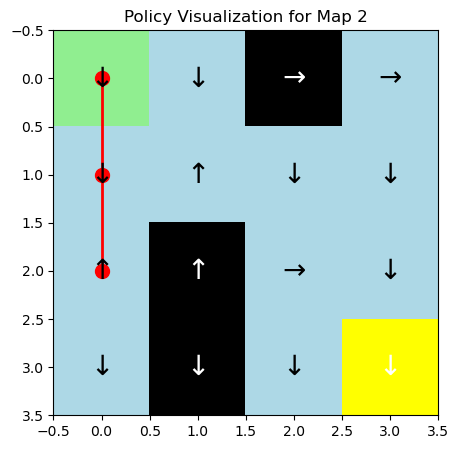

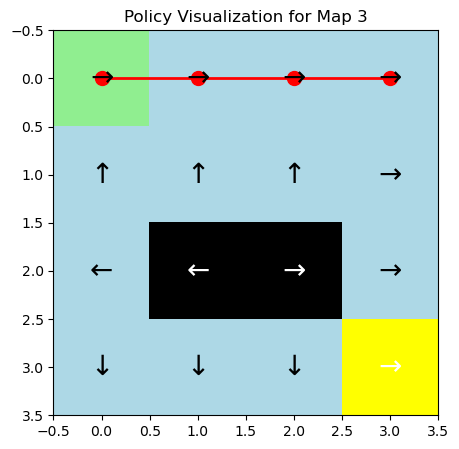

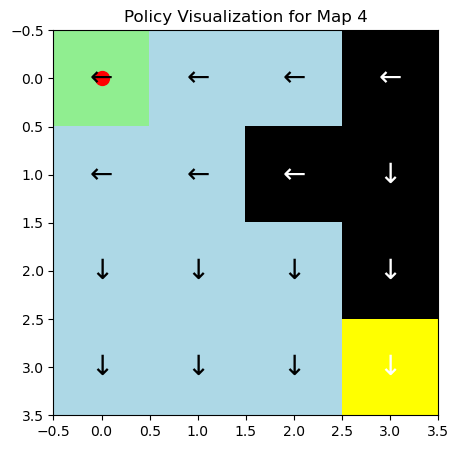

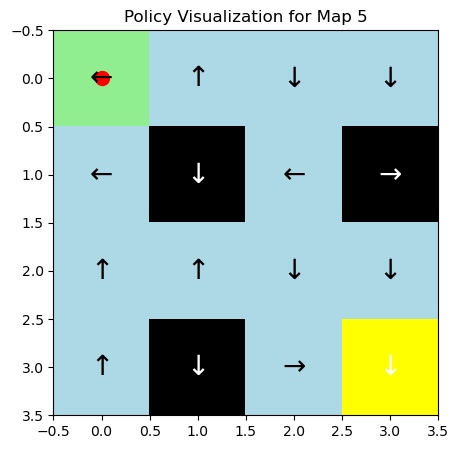

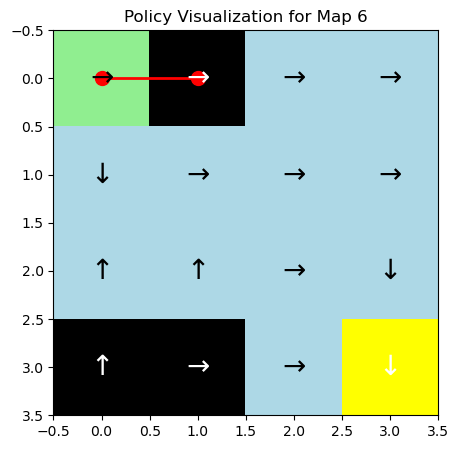

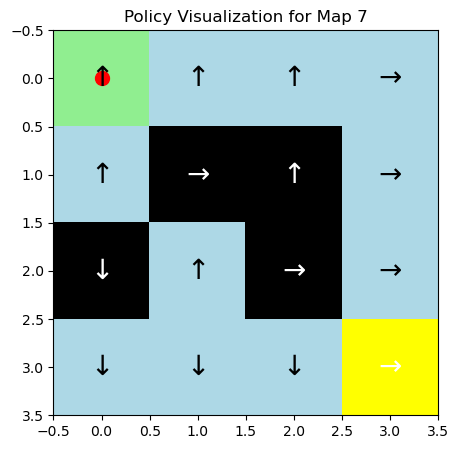

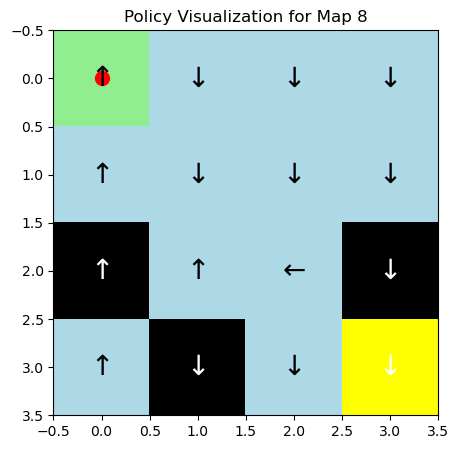

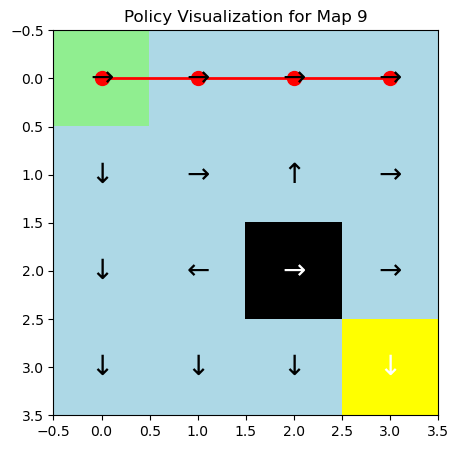

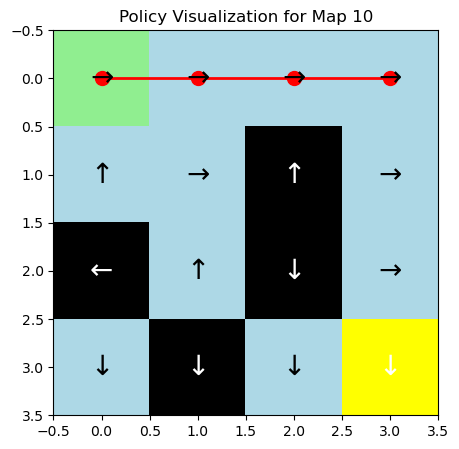

In [246]:
numerical_color_map = {'S': 1, 'F': 0, 'H': 3, 'G': 2}
def visualize_policy_on_random_maps(model, device, n_maps=5, n_states=16, is_slippery=False):
    for map_idx in range(n_maps):
        env = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), is_slippery=is_slippery)
        desc = env.desc.astype(str)

        numerical_grid_colors = np.vectorize(numerical_color_map.get)(desc)

        state_tensors = [preprocess_state(state, env.desc).to(device) for state in range(n_states)]
        batch_states = torch.stack(state_tensors)
        policy_batch = torch.argmax(model(batch_states), dim=1).cpu().numpy()

        action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'}
        policy_symbols = np.vectorize(action_symbols.get)(policy_batch)
        policy_grid = policy_symbols.reshape(env.desc.shape)

        plt.figure(figsize=(5, 5))
        cmap = ListedColormap(['lightblue', 'lightgreen', 'yellow', 'black'])
        plt.imshow(numerical_grid_colors, cmap=cmap, interpolation='nearest')

        # New: Trace the path
        current_position = np.where(desc == 'S')
        i, j = current_position[0][0], current_position[1][0]  # Extracting the start position
        path_x = [j]
        path_y = [i]

        while True:
            action = policy_grid[i, j]
            if action == '←': j -= 1 
            elif action == '→': j += 1
            elif action == '↑': i -= 1
            elif action == '↓': i += 1
            i = min(max(i, 0), desc.shape[0] - 1)  # Ensuring the agent doesn't go out of bounds
            j = min(max(j, 0), desc.shape[1] - 1)
            if (i, j) in zip(path_y, path_x):
                break
            path_x.append(j)
            path_y.append(i)
            if desc[i, j] in ['H', 'G']:
                break

        # Draw the path
        plt.plot(path_x, path_y, 'ro-', linewidth=2, markersize=10)

        for i in range(desc.shape[0]):
            for j in range(desc.shape[1]):
                arrow = policy_grid[i, j]
                arrow_color = 'white' if desc[i, j] in ['H', 'G'] else 'black'
                plt.text(j, i, arrow, ha='center', va='center', fontsize=20, color=arrow_color)

        plt.title(f'Policy Visualization for Map {map_idx+1}')
        plt.show()


visualize_policy_on_random_maps(model, device, n_maps=10, is_slippery=is_slippery)